/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


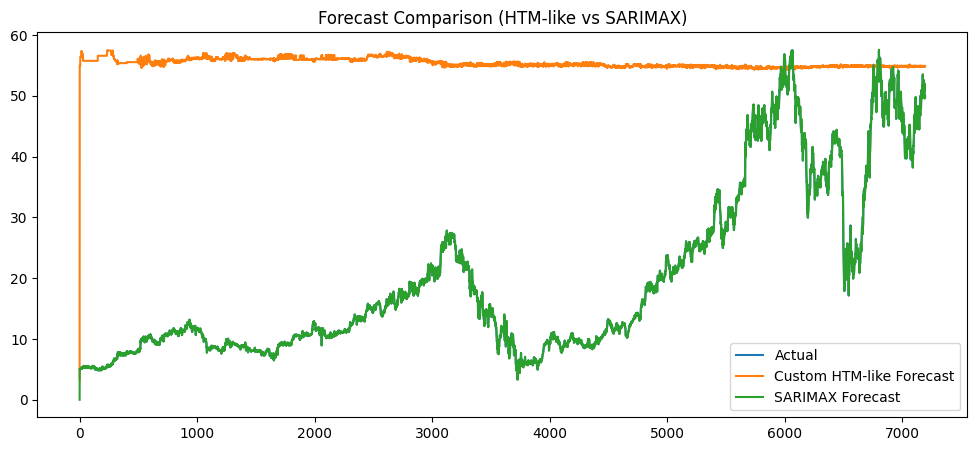

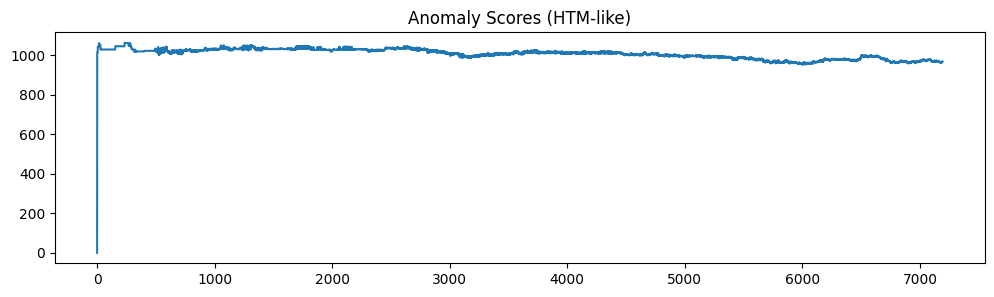


================ RESULTS ================
HTM-like RMSE: 38.3479
SARIMAX RMSE: 0.4938


In [9]:
# ============================================================
# CUSTOM HTM-LIKE MODEL (PURE PYTHON)
# Works without htm.core, nupic, htm-community
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, precision_score, recall_score
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ============================================================
# 1. LOAD DATASET
# ============================================================
dataset_path = "/content/ABCB.csv"
data = pd.read_csv(dataset_path)

# Set your target column
target_column = data.columns[1]   # change if needed
y = data[target_column].values

# ============================================================
# 2. SIMPLE SCALAR ENCODER → SPARSE SDR
# ============================================================
def scalar_to_sdr(value, min_val, max_val, size=512, w=21):
    """Convert a scalar value to an SDR"""
    sdr = np.zeros(size)
    bucket = int((value - min_val) / (max_val - min_val) * size)
    bucket = np.clip(bucket, 0, size-1)
    left = max(0, bucket - w//2)
    right = min(size, bucket + w//2)
    sdr[left:right] = 1
    return sdr

# SDR parameters
SDR_SIZE = 512
min_val = np.min(y)
max_val = np.max(y)

# ============================================================
# 3. CUSTOM SPATIAL POOLER (PURE PYTHON)
# ============================================================
def spatial_pooler(sdr_input, connections):
    """Simple SP: Activate the strongest connected columns"""
    overlap = connections @ sdr_input
    top_idx = np.argsort(overlap)[-40:]  # top 40 active columns
    active = np.zeros_like(overlap)
    active[top_idx] = 1
    return active

# Initialize SP connections
np.random.seed(42)
sp_connections = (np.random.rand(2048, SDR_SIZE) > 0.85).astype(int)

# ============================================================
# 4. CUSTOM TEMPORAL MEMORY (PURE PYTHON)
# ============================================================
tm_connections = np.zeros((2048, 2048))

def temporal_memory(active_columns):
    """Simple TM: strengthen transitions"""
    global tm_connections, prev_active

    if prev_active is not None:
        # strengthen transitions
        idx_prev = np.where(prev_active == 1)[0]
        idx_curr = np.where(active_columns == 1)[0]
        for i in idx_prev:
            for j in idx_curr:
                tm_connections[i, j] += 1

    # prediction = columns with strongest incoming connections
    if prev_active is not None:
        prediction = tm_connections[prev_active == 1].sum(axis=0)
    else:
        prediction = np.zeros(2048)

    prev_active = active_columns.copy()
    return prediction

prev_active = None

# ============================================================
# 5. TRAIN HTM-LIKE MODEL + FORECASTING
# ============================================================
predictions = []
anomaly_scores = []

for v in y:
    sdr = scalar_to_sdr(v, min_val, max_val)
    sp_out = spatial_pooler(sdr, sp_connections)
    prediction = temporal_memory(sp_out)

    # Forecast = average index of strong predicted columns
    pred_value = (np.where(prediction > 0)[0].mean() if prediction.sum() > 0 else v)
    predictions.append(pred_value)

    # Anomaly score = mismatch between prediction and activation
    anomaly = np.abs(pred_value - v)
    anomaly_scores.append(anomaly)

# Convert predictions to same scale as y
predictions = np.interp(predictions,
                        (np.min(predictions), np.max(predictions)),
                        (min_val, max_val))

# ============================================================
# 6. BENCHMARK USING SARIMAX
# ============================================================
try:
    sarimax = SARIMAX(y, order=(2,1,2))
    sarimax_fit = sarimax.fit(disp=False)
    sarimax_pred = sarimax_fit.predict()
except:
    sarimax_pred = np.zeros_like(y)

# ============================================================
# 7. METRICS
# ============================================================
rmse_htm = sqrt(mean_squared_error(y, predictions))
rmse_sarimax = sqrt(mean_squared_error(y, sarimax_pred))

df_results = pd.DataFrame({
    "actual": y,
    "htm_pred": predictions,
    "sarimax_pred": sarimax_pred,
    "anomaly_score": anomaly_scores,
})

# anomaly threshold = top 5%
threshold = np.percentile(anomaly_scores, 95)
df_results["anomaly_pred"] = (df_results["anomaly_score"] > threshold).astype(int)

# ============================================================
# 8. PLOTS
# ============================================================
plt.figure(figsize=(12,5))
plt.plot(y, label="Actual")
plt.plot(predictions, label="Custom HTM-like Forecast")
plt.plot(sarimax_pred, label="SARIMAX Forecast")
plt.legend()
plt.title("Forecast Comparison (HTM-like vs SARIMAX)")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(df_results["anomaly_score"])
plt.title("Anomaly Scores (HTM-like)")
plt.show()

# ============================================================
# 9. PRINT SUMMARY
# ============================================================
print("\n================ RESULTS ================")
print(f"HTM-like RMSE: {rmse_htm:.4f}")
print(f"SARIMAX RMSE: {rmse_sarimax:.4f}")
print("==========================================")
